In [8]:
import os
import shutil
from PIL import Image
import numpy as np
import scipy as sp
from scipy.spatial import distance
import time
from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

# Device configuration
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
#NVIDIA GT 630M - 2.1 <= 3.0 !!! cuDNN error: CUDNN_STATUS_ARCH_MISMATCH
device = torch.device('cpu')
device

device(type='cpu')

In [2]:
dir_ = "data"
market_path_train = "/Market-1501-v15.09.15/bounding_box_train"
market_path_test = "/Market-1501-v15.09.15/bounding_box_test"
market_path_query = "/Market-1501-v15.09.15/query"
dist_market_path_train = "/trainClasses"
dist_market_path_test = "/testClasses"
dist_market_path_query = "/queryClasses"
dist_market_path_smallTest = "/smallTest"
dist_market_path_smallQuery = "/smallQuery"

In [3]:
def load_train_dataset(path, batch_size=1, shuffle=False):
    data_path = dir_ + path
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transforms.Compose([
            #torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor()
        ])
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=shuffle
    )
    return train_loader

def load_test_dataset(path, batch_size=1, shuffle=False):
    data_path = dir_ + path
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.ToTensor()
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=shuffle
    )
    return train_loader

In [4]:
def find_distance_one(object_with_features, test_features):
    list_dist = []
    for index in range(len(test_features)):
        dist_ = distance.cosine(object_with_features[1], test_features[index][1])
        list_dist.append((test_features[index][0], dist_, index))
    list_dist.sort(key=lambda tup: tup[1])
    result = (object_with_features[0], list_dist, object_with_features[2])
    return result

def find_distance_all(query_features, test_features):
    result = []
    for i in range(len(query_features)):
        distances_for_object = find_distance_one(object_with_features=query_features[i],
                                                 test_features=test_features)
        result.append(distances_for_object)
    return result

def find_distance_all_v(query_features, test_features):
    result = []
    for i in tqdm_notebook(range(len(query_features))):
        distances_for_object = find_distance_one(object_with_features=query_features[i],
                                                 test_features=test_features)
        result.append(distances_for_object)
    return result

def mAP(rangs, path_="data/testClasses/"):
    #{ { str_path, { {str_path_r_1, p_r_1}, {str_path_r_2, p_r_2}, .. {str_path_r_n, p_r_1} } }, ... }

    len_rangs = len(rangs) #751
    #print(len_rangs)
    sum_mAP = 0

    for rang in rangs:
        person = str(rang[0])
        len_person = len(os.listdir(path_ + str("{:0>4s}".format(person)) + '/'))
        sum_P = 0
        sum_true = 0
        i = 0
        for rang_r in rang[1]:
            i += 1
            if rang_r[0] == person:
                sum_true += 1
                sum_P += sum_true/i
            #print("Person: ", person, rang_r[0].split('_')[0], sum_true/i)
        #print("Person:", person, "len_person:", str(len_person), "AP =", sum_P/len_person)
        sum_mAP += sum_P/len_person
    return sum_mAP/len_rangs

In [5]:
def test_model(model, test_loader, query_loader, path_, v=False):
    test_features = []
    print("Waiting output from test_loader...")
    with torch.no_grad():
        for images, labels in test_loader:
            outputs2, outputs1 = model(images)
            test_features.append((str(labels.tolist()[0]), outputs1, images[0].numpy()))
    len(test_features)

    query_features = []
    print("Waiting output from query_loader...")
    with torch.no_grad():
        for images, labels in query_loader:
            outputs2, outputs1 = model(images)
            query_features.append((str(labels.tolist()[0]), outputs1, images[0].numpy()))
    len(query_features)
    
    print("Waiting mAP...")
    if v == False:
        rangs = find_distance_all(query_features=query_features, test_features=test_features)
    if v == True:
        rangs = find_distance_all_v(query_features=query_features, test_features=test_features)
    return mAP(rangs=rangs, path_=path_)

In [44]:
#inplace = 3 - кол-во входных каналов (RGB)

class CNN_ReID(nn.Module):
    def __init__(self, inplanes=3, planes1=8, planes2=16, planes3=32, stride=1):
        super(CNN_ReID, self).__init__()

        self.layer1 = nn.Sequential(nn.Conv2d(inplanes, planes1, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(nn.Conv2d(planes1, planes2, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(nn.Conv2d(planes2, planes3, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        #self.drop_out = nn.Dropout() 
        self.fc1 = nn.Linear(16 * 8 * planes3, 128) # 16*8*32 = 4096
        self.fc2 = nn.Linear(128, 751)
    def forward(self, x): 
        out = self.layer1(x) 
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        #out = self.drop_out(out)
        out1 = self.fc1(out)
        out2 = self.fc2(out1)
        return out2, out1

In [45]:
def trainModel(num_epochs=10, weight_decay=0.001, momentum=0.9, learning_rate=0.01, name="model_0.ckpt",
               train_loader=None, test_loader=None, query_loader=None, model=None):
    model = model
    criterion = nn.CrossEntropyLoss() # CrossEntropyLoss() объединяет и SoftMax, и кросс-энтропийную функцию потерь
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)

    total_step = len(train_loader)
    loss_list = []
    acc_list = []
    list_mAP = []
    acc_list_ret = []
    loss_list_ret = []

    best_mAP = -1
    
    print("wd =",weight_decay, "momentum =", momentum, "lr = ", learning_rate)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device) 
            labels = labels.to(device)

            # Прямой запуск
            outputs2, outputs1 = model(images)
            loss = criterion(outputs2, labels)
            loss_list.append(loss.item())

            # Обратное распространение и оптимизатор
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Отслеживание точности
            total = labels.size(0)
            _, predicted = torch.max(outputs2.data, 1)
            correct = (predicted == labels).sum().item()
            acc_list.append(correct / total)
            
            if (i + 1) % (total_step-1) == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.8f}%'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                              (correct / total)))
                
        new_mAP = test_model(model=model, test_loader=test_loader, query_loader=query_loader,
                             path_="data/smallTest/")
        if (new_mAP >= best_mAP):
            torch.save(model.state_dict(), name)
            best_mAP = new_mAP
            bestEpoch = epoch
            print("bestModel was found! mAP: {:.4f}, epoch: {:d}".format(best_mAP, bestEpoch))
        list_mAP.append(new_mAP)
        acc_list_ret.append(correct / total)
        loss_list_ret.append(loss.item())
                
                
    print("LOSS =", loss.item(), "wd =", weight_decay, "momentum =",
          momentum, "lr =", learning_rate, "best_mAP =", best_mAP, "bestEpoch =", bestEpoch)
    plt.figure(figsize=(16,10));
    plt.plot(range(num_epochs),list_mAP);
    return list_mAP, acc_list_ret, loss_list_ret

## Test

In [107]:
train_loader = load_train_dataset(dist_market_path_train, batch_size=500, shuffle=True)

test_loader = load_test_dataset(dist_market_path_smallTest, batch_size=1, shuffle=False)
query_loader = load_test_dataset(dist_market_path_smallQuery, batch_size=1, shuffle=False)

wd = 0.005 momentum = 0.9 lr =  0.03
Epoch [1/40], Step [25/26], Loss: 6.5969, Accuracy: 0.00000000%
Waiting output from test_loader...
Waiting output from query_loader...
Waiting mAP...
bestModel was found! mAP: 0.1357, epoch: 0
Epoch [2/40], Step [25/26], Loss: 6.5368, Accuracy: 0.00200000%
Waiting output from test_loader...
Waiting output from query_loader...
Waiting mAP...
Epoch [3/40], Step [25/26], Loss: 6.3522, Accuracy: 0.01000000%
Waiting output from test_loader...
Waiting output from query_loader...
Waiting mAP...
Epoch [4/40], Step [25/26], Loss: 5.9986, Accuracy: 0.02800000%
Waiting output from test_loader...
Waiting output from query_loader...
Waiting mAP...
Epoch [5/40], Step [25/26], Loss: 5.6566, Accuracy: 0.03200000%
Waiting output from test_loader...
Waiting output from query_loader...
Waiting mAP...
bestModel was found! mAP: 0.1416, epoch: 4
Epoch [6/40], Step [25/26], Loss: 5.1615, Accuracy: 0.07800000%
Waiting output from test_loader...
Waiting output from query_lo

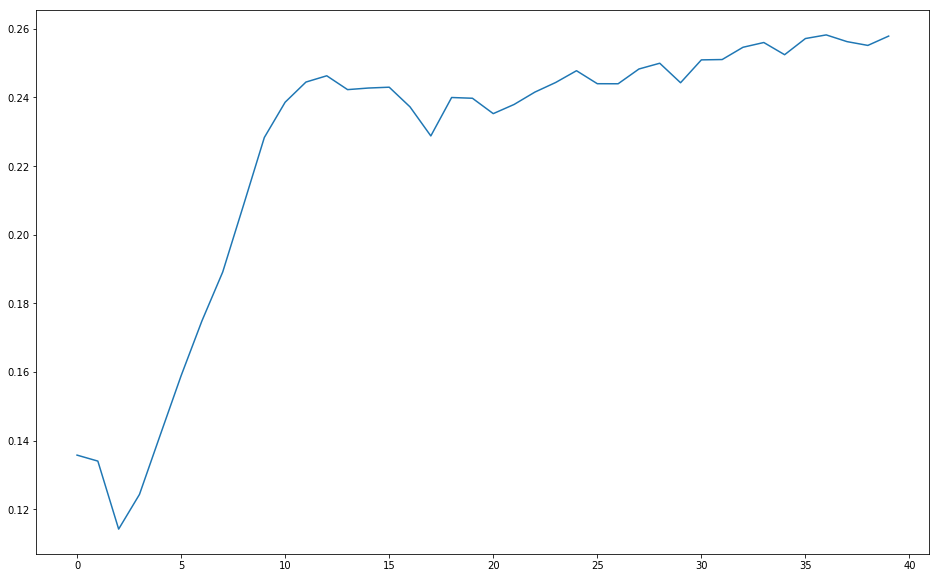

In [108]:
start_time = time.time()
ret_mAP_1, ret_acc_1, ret_loss_1 = trainModel(num_epochs=40,
                                              weight_decay=0.005,
                                              momentum=0.9,
                                              learning_rate=0.03,
                                              name="model_result_1_conv.ckpt",
                                              train_loader=train_loader,
                                              test_loader=test_loader,
                                              query_loader=query_loader,
                                              model=CNN_ReID().to(device))

print("Time = ", time.time() - start_time)

## Conv + BatchNorm

In [88]:
#inplace = 3 - кол-во входных каналов (RGB)

class CNN_ReID_BN(nn.Module):
    def __init__(self, inplanes=3, planes1=8, planes2=16, planes3=32, stride=1):
        super(CNN_ReID_BN, self).__init__()

        self.layer1 = nn.Sequential(nn.Conv2d(inplanes, planes1, kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm2d(planes1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(nn.Conv2d(planes1, planes2, kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm2d(planes2),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(nn.Conv2d(planes2, planes3, kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm2d(planes3),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        #self.drop_out = nn.Dropout() 
        self.fc1 = nn.Linear(16 * 8 * planes3, 128) # 16*8*32 = 4096
        self.fc2 = nn.Linear(128, 751)
    def forward(self, x): 
        out = self.layer1(x) 
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        #out = self.drop_out(out)
        out1 = self.fc1(out)
        out2 = self.fc2(out1)
        return out2, out1

wd = 0.005 momentum = 0.9 lr =  0.05
Epoch [1/40], Step [12/13], Loss: 6.4183, Accuracy: 0.01100000%
Waiting output from test_loader...
Waiting output from query_loader...
Waiting mAP...
bestModel was found! mAP: 0.2001, epoch: 0
Epoch [2/40], Step [12/13], Loss: 5.8195, Accuracy: 0.06100000%
Waiting output from test_loader...
Waiting output from query_loader...
Waiting mAP...
bestModel was found! mAP: 0.2465, epoch: 1
Epoch [3/40], Step [12/13], Loss: 4.9991, Accuracy: 0.12200000%
Waiting output from test_loader...
Waiting output from query_loader...
Waiting mAP...
bestModel was found! mAP: 0.2898, epoch: 2
Epoch [4/40], Step [12/13], Loss: 3.9732, Accuracy: 0.24200000%
Waiting output from test_loader...
Waiting output from query_loader...
Waiting mAP...
bestModel was found! mAP: 0.3173, epoch: 3
Epoch [5/40], Step [12/13], Loss: 2.9327, Accuracy: 0.37200000%
Waiting output from test_loader...
Waiting output from query_loader...
Waiting mAP...
bestModel was found! mAP: 0.3424, epoch: 

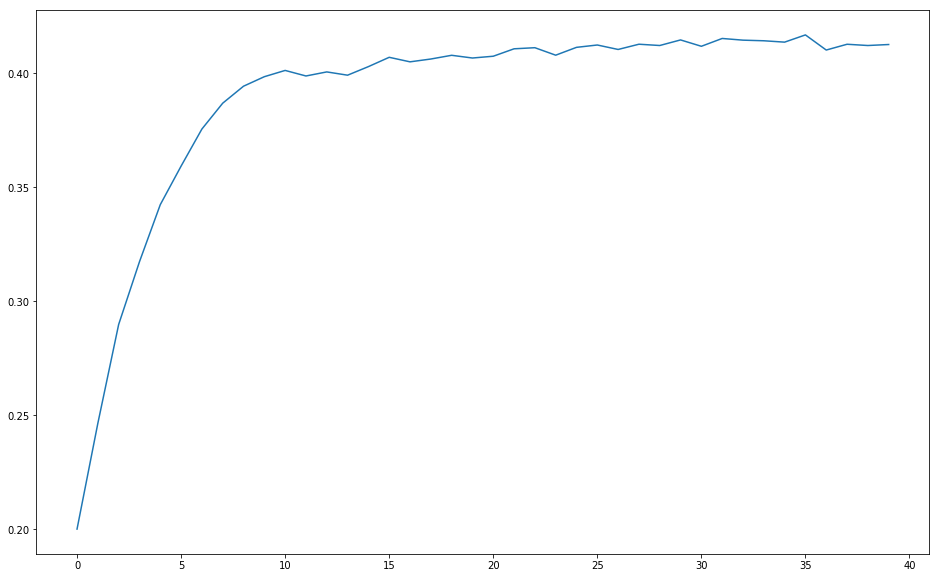

In [89]:
start_time = time.time()
ret_mAP_2, ret_acc_2, ret_loss_2 = trainModel(num_epochs=40,
                                              weight_decay=0.005,
                                              momentum=0.9,
                                              learning_rate=0.05,
                                              name="model_result_2_conv_bn.ckpt",
                                              train_loader=train_loader,
                                              test_loader=test_loader,
                                              query_loader=query_loader,
                                              model=CNN_ReID_BN().to(device))

print("Time = ", time.time() - start_time)

## Conv + BatchNorm + Self-Attention_last

In [58]:
class Self_Attn(nn.Module):
    """ Self attention Layer"""
    def __init__(self,in_dim):
        super(Self_Attn,self).__init__()
        self.chanel_in = in_dim
        
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out

In [60]:
#inplace = 3 - кол-во входных каналов (RGB)

class CNN_ReID_BN_SA_last(nn.Module):
    def __init__(self, inplanes=3, planes1=8, planes2=16, planes3=32, stride=1):
        super(CNN_ReID_BN_SA_last, self).__init__()

        self.layer1 = nn.Sequential(nn.Conv2d(inplanes, planes1, kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm2d(planes1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(nn.Conv2d(planes1, planes2, kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm2d(planes2),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(nn.Conv2d(planes2, planes3, kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm2d(planes3),
                                    nn.ReLU(),
                                    Self_Attn(planes3),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        #self.drop_out = nn.Dropout() 
        self.fc1 = nn.Linear(16 * 8 * planes3, 128) # 16*8*32 = 4096
        self.fc2 = nn.Linear(128, 751)
    def forward(self, x): 
        out = self.layer1(x) 
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        #out = self.drop_out(out)
        out1 = self.fc1(out)
        out2 = self.fc2(out1)
        return out2, out1

In [62]:
train_loader = load_train_dataset(dist_market_path_train, batch_size=500, shuffle=True)

test_loader = load_test_dataset(dist_market_path_smallTest, batch_size=1, shuffle=False)
query_loader = load_test_dataset(dist_market_path_smallQuery, batch_size=1, shuffle=False)

wd = 0.005 momentum = 0.9 lr =  0.05
Epoch [1/40], Step [25/26], Loss: 6.0101, Accuracy: 0.02200000%
Waiting output from test_loader...
Waiting output from query_loader...
Waiting mAP...
bestModel was found! mAP: 0.2384, epoch: 0
Epoch [2/40], Step [25/26], Loss: 4.5600, Accuracy: 0.15600000%
Waiting output from test_loader...
Waiting output from query_loader...
Waiting mAP...
bestModel was found! mAP: 0.2955, epoch: 1
Epoch [3/40], Step [25/26], Loss: 3.1887, Accuracy: 0.35200000%
Waiting output from test_loader...
Waiting output from query_loader...
Waiting mAP...
bestModel was found! mAP: 0.3417, epoch: 2
Epoch [4/40], Step [25/26], Loss: 2.1694, Accuracy: 0.48200000%
Waiting output from test_loader...
Waiting output from query_loader...
Waiting mAP...
bestModel was found! mAP: 0.3785, epoch: 3
Epoch [5/40], Step [25/26], Loss: 1.2878, Accuracy: 0.72200000%
Waiting output from test_loader...
Waiting output from query_loader...
Waiting mAP...
bestModel was found! mAP: 0.3941, epoch: 

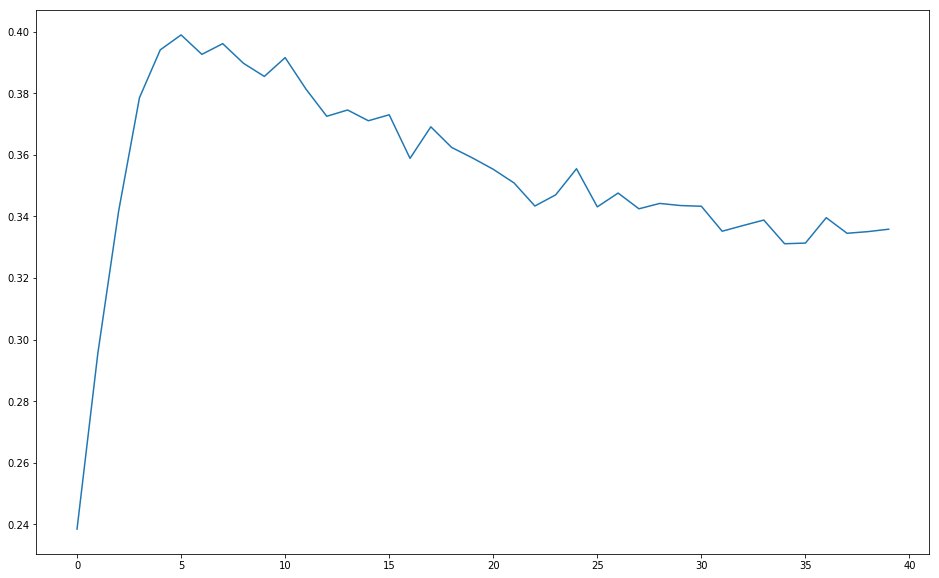

In [65]:
start_time = time.time()
ret_mAP_3, ret_acc_3, ret_loss_3 = trainModel(num_epochs=40,
                                              weight_decay=0.005,
                                              momentum=0.9,
                                              learning_rate=0.05,
                                              name="model_result_3_conv_bn.ckpt",
                                              train_loader=train_loader,
                                              test_loader=test_loader,
                                              query_loader=query_loader,
                                              model=CNN_ReID_BN_SA_last().to(device))

print("Time = ", time.time() - start_time)

## Conv + BatchNorm + (Self-Attention_last + BatchNorm)

In [84]:
class Self_Attn_BN(nn.Module):
    """ Self attention Layer"""
    def __init__(self,in_dim):
        super(Self_Attn_BN,self).__init__()
        self.chanel_in = in_dim
        
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.bn_query = nn.BatchNorm2d(in_dim//8)
        self.bn_key = nn.BatchNorm2d(in_dim//8)
        self.bn_value = nn.BatchNorm2d(in_dim)

        self.softmax  = nn.Softmax(dim=-1) #
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        
        proj_query  = self.bn_query(self.query_conv(x)).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.bn_key(self.key_conv(x)).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.bn_value(self.value_conv(x)).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out

In [85]:
#inplace = 3 - кол-во входных каналов (RGB)

class CNN_ReID_BN_SA_last_BN(nn.Module):
    def __init__(self, inplanes=3, planes1=8, planes2=16, planes3=32, stride=1):
        super(CNN_ReID_BN_SA_last_BN, self).__init__()

        self.layer1 = nn.Sequential(nn.Conv2d(inplanes, planes1, kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm2d(planes1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(nn.Conv2d(planes1, planes2, kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm2d(planes2),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(nn.Conv2d(planes2, planes3, kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm2d(planes3),
                                    nn.ReLU(),
                                    Self_Attn_BN(planes3),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        #self.drop_out = nn.Dropout() 
        self.fc1 = nn.Linear(16 * 8 * planes3, 128) # 16*8*32 = 4096
        self.fc2 = nn.Linear(128, 751)
    def forward(self, x): 
        out = self.layer1(x) 
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        #out = self.drop_out(out)
        out1 = self.fc1(out)
        out2 = self.fc2(out1)
        return out2, out1

wd = 0.005 momentum = 0.9 lr =  0.05
Epoch [1/40], Step [25/26], Loss: 6.0620, Accuracy: 0.03600000%
Waiting output from test_loader...
Waiting output from query_loader...
Waiting mAP...
bestModel was found! mAP: 0.2271, epoch: 0
Epoch [2/40], Step [25/26], Loss: 4.7754, Accuracy: 0.11800000%
Waiting output from test_loader...
Waiting output from query_loader...
Waiting mAP...
bestModel was found! mAP: 0.2609, epoch: 1
Epoch [3/40], Step [25/26], Loss: 3.0998, Accuracy: 0.31800000%
Waiting output from test_loader...
Waiting output from query_loader...
Waiting mAP...
bestModel was found! mAP: 0.3223, epoch: 2
Epoch [4/40], Step [25/26], Loss: 2.1604, Accuracy: 0.48400000%
Waiting output from test_loader...
Waiting output from query_loader...
Waiting mAP...
bestModel was found! mAP: 0.3757, epoch: 3
Epoch [5/40], Step [25/26], Loss: 1.4550, Accuracy: 0.65400000%
Waiting output from test_loader...
Waiting output from query_loader...
Waiting mAP...
bestModel was found! mAP: 0.3906, epoch: 

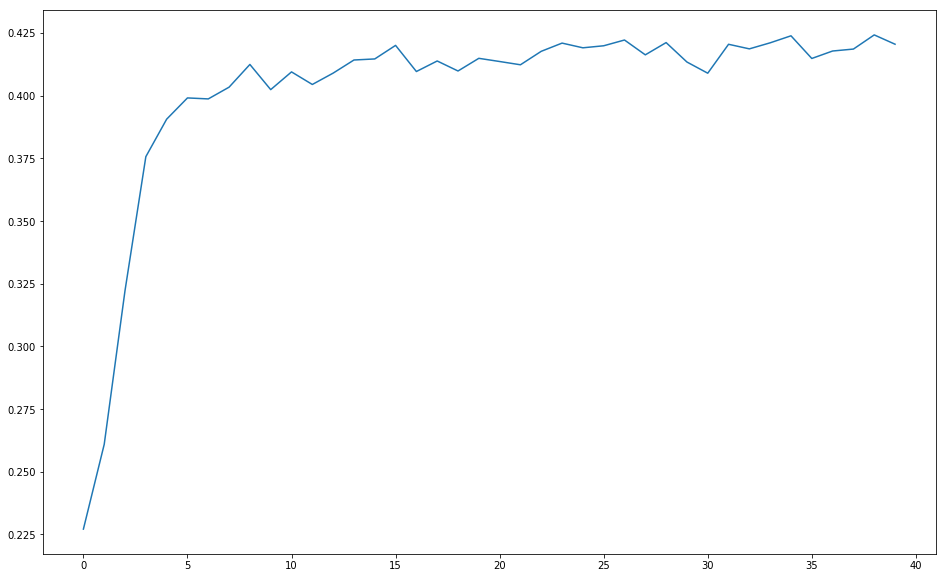

In [86]:
start_time = time.time()
ret_mAP_4, ret_acc_4, ret_loss_4 = trainModel(num_epochs=40,
                                              weight_decay=0.005,
                                              momentum=0.9,
                                              learning_rate=0.05,
                                              name="model_result_4_conv_bn.ckpt",
                                              train_loader=train_loader,
                                              test_loader=test_loader,
                                              query_loader=query_loader,
                                              model=CNN_ReID_BN_SA_last_BN().to(device))

print("Time = ", time.time() - start_time)

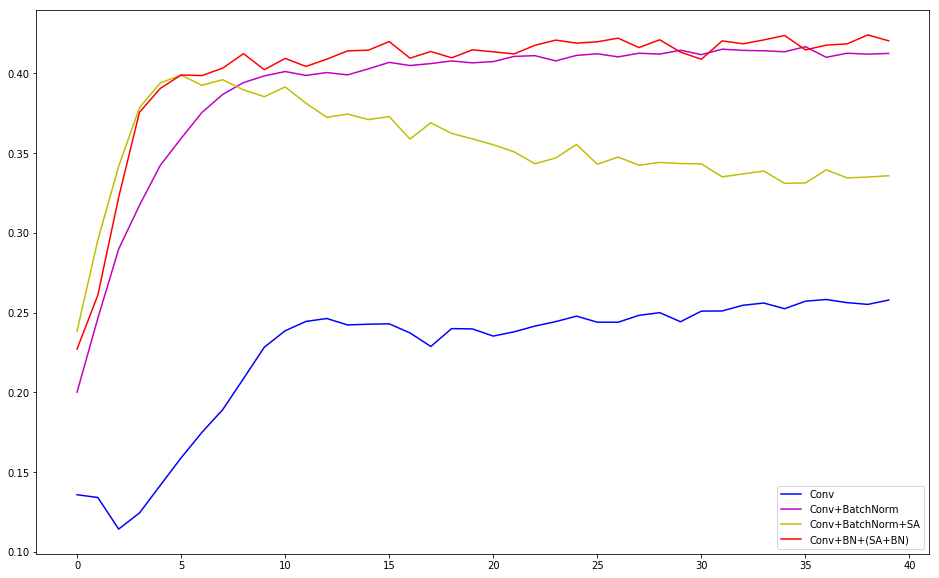

In [109]:
num_epochs = 40

plt.figure(figsize=(16,10))
line1, = plt.plot(range(num_epochs),ret_mAP_1, 'b', label='Conv')
line2, = plt.plot(range(num_epochs),ret_mAP_2, 'm', label='Conv+BatchNorm')
line3, = plt.plot(range(num_epochs),ret_mAP_3, 'y', label='Conv+BatchNorm+SA')
line4, = plt.plot(range(num_epochs),ret_mAP_4, 'r', label='Conv+BN+(SA+BN)')
plt.legend(handles=[line1, line2, line3, line4]);

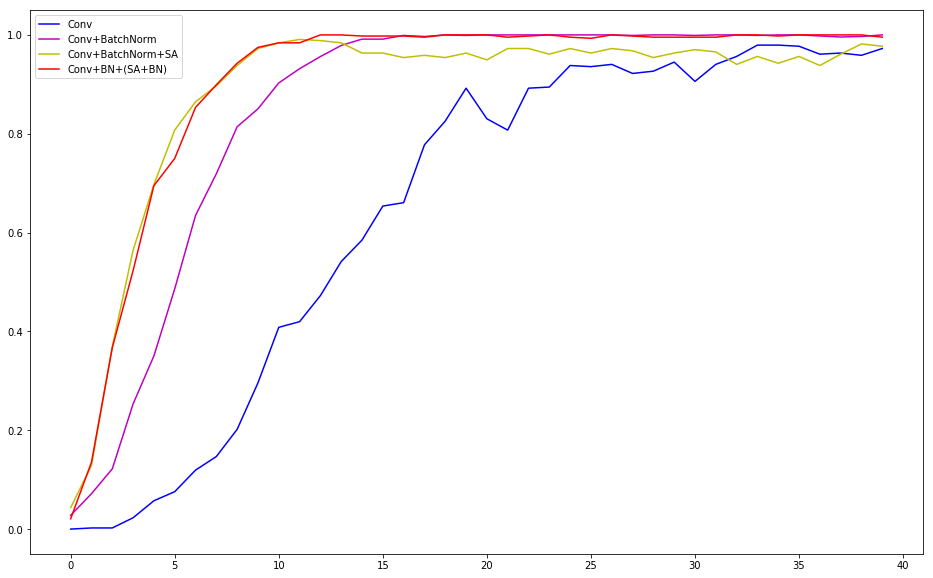

In [110]:
num_epochs = 40

plt.figure(figsize=(16,10))
line1, = plt.plot(range(num_epochs),ret_acc_1, 'b', label='Conv')
line2, = plt.plot(range(num_epochs),ret_acc_2, 'm', label='Conv+BatchNorm')
line3, = plt.plot(range(num_epochs),ret_acc_3, 'y', label='Conv+BatchNorm+SA')
line4, = plt.plot(range(num_epochs),ret_acc_4, 'r', label='Conv+BN+(SA+BN)')
plt.legend(handles=[line1, line2, line3, line4]);

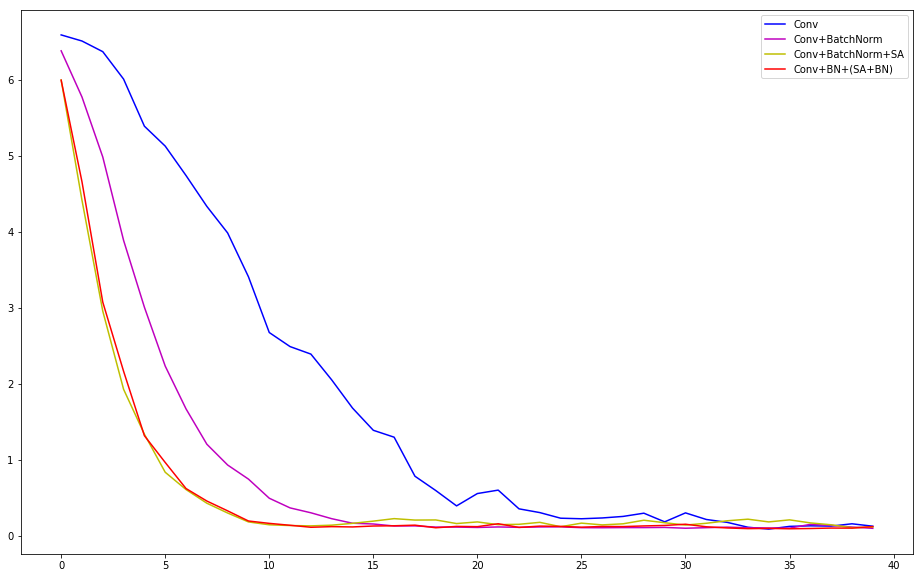

In [111]:
num_epochs = 40

plt.figure(figsize=(16,10))
line1, = plt.plot(range(num_epochs),ret_loss_1, 'b', label='Conv')
line2, = plt.plot(range(num_epochs),ret_loss_2, 'm', label='Conv+BatchNorm')
line3, = plt.plot(range(num_epochs),ret_loss_3, 'y', label='Conv+BatchNorm+SA')
line4, = plt.plot(range(num_epochs),ret_loss_4, 'r', label='Conv+BN+(SA+BN)')
plt.legend(handles=[line1, line2, line3, line4]);